In [1]:
import logging
import boto3
import pandas as pd
import json
from botocore.exceptions import ClientError

from nltk.corpus import stopwords
from sklearn import preprocessing
import re
import matplotlib.pyplot as plt

personalize = boto3.client('personalize')

roleArn   = 'arn:aws:iam::{aws-account}:role/service-role/AmazonPersonalize-ExecutionRole'
s3_bucket = '{bucket_name}'

In [2]:


def create_schema(name, schemaFile):
    try:
        with open(schemaFile) as f:
            createSchemaResponse = personalize.create_schema(
                name = name,
                schema = f.read()
            )

        createSchemaResponse['schemaArn']
    except Exception as e:
        print(e)
        
    schema_arn = personalize.list_schemas()
    schema_arn = list(map(lambda x : {x['name'] : x['schemaArn']}, schema_arn['schemas']))
    return {k: v for d in schema_arn for k, v in d.items()}

def upload_file(file_name, file_dest):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param file_dest: Bucket to upload to
    :return: True if file was uploaded, else False
    """
    s3 = boto3.resource('s3')

#     s3.Bucket(BUCKET).upload_file('exports/USERS.csv', "personalize/USERS.csv")

    try:
        response = s3.Bucket(s3_bucket).upload_file(file_name, file_dest)
    except ClientError as e:
        logging.error(e)
        return False
    return True

def crate_dataset(name, schemaArn, datasetGroupArn, datasetType):
    try:
        response = personalize.create_dataset(
            name = name,
            schemaArn = schemaArn,
            datasetGroupArn = datasetGroupArn,
            datasetType = datasetType)
    except Exception as e:
        print(e)
        
    dataset_arn = personalize.list_datasets()
#     print(dataset_arn)
    dataset_arn = list(map(lambda x : {x['name'] : x['datasetArn']}, dataset_arn['datasets']))
    return {k: v for d in dataset_arn for k, v in d.items()}


def clean(x):
    x = x.lower()
    x = re.sub('[^\x00-\x7F]+', ' ', x)
    x = re.sub('[^\w\s]', ' ', x)    
    x = re.sub('^\s*$', 'none', x)
    stop = stopwords.words('english')
    x = [word for word in x.split() if x not in stop]
    return "|".join(x)

In [3]:
# Delete
# personalize.delete_schema(schemaArn= 'arn:aws:personalize:us-east-1:{aws_account}:schema/UserSchema')


# USERS

In [4]:
# USERS
df_user = pd.read_csv('data/USERS.csv')
df_user.columns =  ['USER_ID', 'USER_SCORE', 'GEO_GROUP', 'LANGUAGE']

df_user = df_user.sample(frac=0.25, replace=True, random_state=1)
df_user.to_csv('exports/USERS.csv', index=False)
df_user.reset_index(drop=True)

upload_file('exports/USERS.csv', 'personalize/USERS.csv')
print('number of users in dataset: ', df_user.size)
df_user.tail(20)

number of users in dataset:  1048576


,USER_ID,USER_SCORE,GEO_GROUP,LANGUAGE
187553,12090644,4,20,ms
94675,6435143,4,3,es
889940,25324885,4,89,es
311945,18726113,4,14,en
708135,24958746,3,8,en
193775,12388193,4,5,pt
985515,25572470,3,5,pt
990060,25584112,3,8,en
154339,10173191,3,8,en
1030868,25688304,4,5,pt


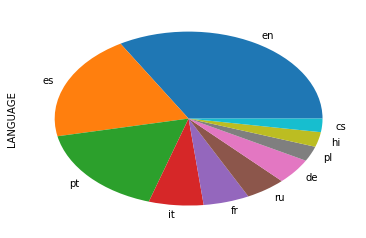

In [5]:
df_user['LANGUAGE'].value_counts(sort=True)[:10].plot.pie()

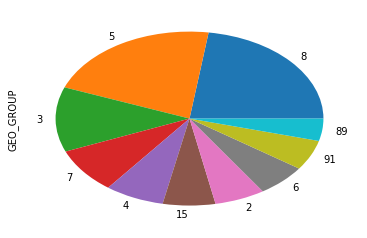

In [6]:
df_user['GEO_GROUP'].value_counts(sort=True)[:10].plot.pie()

In [7]:
users = {
    'type': 'record',
    'name': 'Users',
    'namespace': 'com.amazonaws.personalize.schema',
    'fields': [
        {
            'name': 'USER_ID',
            'type': 'string'
        },
        {
            'name': 'USER_SCORE',
            'type': 'long'
        },
        {
            'name': 'GEO_GROUP',
            'type': 'int',
            'categorical': True
        },
        {
            'name': 'LANGUAGE',
            'type': 'string',
            'categorical': True
        }
    ],
    'version': '1.0'
}

with open('schema/users.json', 'w') as json_file:
    json.dump(users, json_file, indent = 4)
    
schema_arn = create_schema(name = 'UserSchema', schemaFile = 'schema/users.json')
print(schema_arn) 

datasete_arn = crate_dataset(name = 'UserDataset',
        schemaArn = schema_arn['UserSchema'],
        datasetGroupArn = 'arn:aws:personalize:us-east-1::dataset-group/MadlipzDatasetGroup',
        datasetType = 'Users')
print(datasete_arn)

An error occurred (ResourceAlreadyExistsException) when calling the CreateSchema operation: Another resource with Arn arn:aws:personalize:us-east-1::schema/UserSchema already exists.
{'InteractionSchema': 'arn:aws:personalize:us-east-1::schema/InteractionSchema', 'ItemSchema': 'arn:aws:personalize:us-east-1::schema/ItemSchema', 'UserSchema': 'arn:aws:personalize:us-east-1::schema/UserSchema'}
{'UserDataset': 'arn:aws:personalize:us-east-1::dataset/MadlipzDatasetGroup/USERS'}


# Items

In [8]:
# df_item = pd.read_csv('data/ITEMS.csv')
# df_item.tail()

In [9]:
# ITEMS
df_item = pd.read_csv('data/ITEMS.csv')
df_item['clip_category'] = df_item['clip_category'].astype(str).apply(lambda x: clean(x))
# df_item['clip_keywords'] = df_item['clip_keywords'].astype(str).apply(lambda x: clean(x))
# df_item['clip_title'] = df_item['clip_title'].astype(str).apply(lambda x: clean(x))

df_item = df_item.dropna()
# df_item = df_item.sample(frac=0.8, replace=True, random_state=1)

df_item['post_timestamp'] = pd.to_datetime(df_item['post_timestamp']).dt.date
df_item['post_timestamp'] = pd.to_datetime(df_item['post_timestamp']).astype('int64')//1e9

df_item.drop(['post_geo_group', 'post_meta_plays', 'post_views', 
              'clip_keywords', 'clip_title'], axis=1, inplace=True)

min_max_scaler = preprocessing.RobustScaler()
df_item['posts_score'] = min_max_scaler.fit_transform(df_item[['posts_score']])


df_item.columns = ['ITEM_ID', 'CLIP_CATEGORY', 'POST_FEATURED', 'POST_COUNTRY',
                   'POST_LANGUAGE', 'POST_SCORE', 'POST_SHARES', 'TIMESTAMP'
                  ]
df_item.to_csv('exports/ITEMS.csv', index=False)

# df_item['POST_SCORE'].plot(kind='bar')
print(df_item['POST_SCORE'].value_counts(bins=3)) 
# print(df_item['TIMESTAMP'].value_counts())

upload_file('exports/ITEMS.csv', 'personalize/ITEMS.csv')
print('number of items:', df_item.size)
df_item.tail()

(-0.579, 81.333]    181006
(81.333, 163.0]         23
(163.0, 244.667]         3
Name: POST_SCORE, dtype: int64
number of items: 1448256


,ITEM_ID,CLIP_CATEGORY,POST_FEATURED,POST_COUNTRY,POST_LANGUAGE,POST_SCORE,POST_SHARES,TIMESTAMP
181592,49762113,memes,1,BR,pt,-0.333333,28,1546300800
181593,49762035,animals,-1,SG,en,0.000000,31,1546300800
181594,49762027,memes|crying,1,BR,pt,0.333333,64,1546300800
181595,49761989,animals|monkeys,1,BR,pt,-0.333333,3,1546300800
181596,49761945,movies|act|lipsync,1,BR,pt,-0.333333,0,1546300800


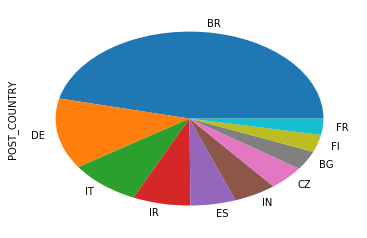

In [10]:
df_item['POST_COUNTRY'].value_counts(sort=True)[:10].plot.pie()

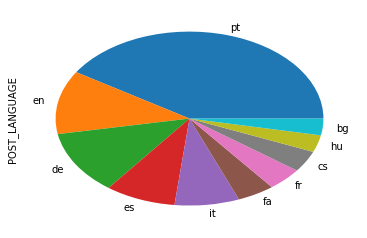

In [11]:
df_item['POST_LANGUAGE'].value_counts(sort=True)[:10].plot.pie()

In [12]:
items = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CLIP_CATEGORY",
            "type": "string",
            "categorical": True
        },
        {
            "name": "POST_FEATURED",
            "type": "int"
        },
        {
            "name": "POST_COUNTRY",
            "type": "string",
            "categorical": True
        },
        {
            "name": "POST_LANGUAGE",
            "type": "string",
            "categorical": True
        },
        {
            "name": "POST_SCORE",
            "type": "float"
        },
        {
            "name": "POST_SHARES",
            "type": "int"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}
# ITEM_ID,CLIP_CATEGORY,CLIP_KEYWORDS,CLIP_TITLE,POST_FEATURED,POST_COUNTRY,POST_LANGUAGE,POST_SCORE,POST_SHARES,POST_TIMESTAMP

with open('schema/items.json', 'w') as json_file:
    json.dump(items, json_file, indent = 4)

    
# personalize.delete_schema(schemaArn= 'arn:aws:personalize:us-east-1::schema/ItemSchema')

schema_arn = create_schema(name = 'ItemSchema', schemaFile = 'schema/items.json')
print(schema_arn)   


dataset_arn = crate_dataset(name = 'ItemsDataset',
        schemaArn = schema_arn['ItemSchema'],
        datasetGroupArn = 'arn:aws:personalize:us-east-1::dataset-group/MadlipzDatasetGroup',
        datasetType = 'Items')
print(datasete_arn)

An error occurred (ResourceAlreadyExistsException) when calling the CreateSchema operation: Another resource with Arn arn:aws:personalize:us-east-1::schema/ItemSchema already exists.
{'InteractionSchema': 'arn:aws:personalize:us-east-1::schema/InteractionSchema', 'ItemSchema': 'arn:aws:personalize:us-east-1::schema/ItemSchema', 'UserSchema': 'arn:aws:personalize:us-east-1::schema/UserSchema'}
{'UserDataset': 'arn:aws:personalize:us-east-1::dataset/MadlipzDatasetGroup/USERS'}


# Interactions

In [13]:
df_interaction = pd.read_csv('data/INTERACTIONS.csv')

# filter interactions based on the dataset
# df_interaction = df_interaction[df_interaction['item_id'].isin(df_item['ITEM_ID'])]
df_interaction = df_interaction[df_interaction['user_id'].isin(df_user['USER_ID'])]

df_interaction = df_interaction.drop_duplicates(['item_id', 'user_id'], keep= 'last').reset_index()
df_interaction['post_timestamp'] = pd.to_datetime(df_interaction['post_timestamp']).astype('int64')//1e9

# df_interaction = df_interaction.sample(frac=0.5, replace=True, random_state=1)

# df_interaction.reset_index(drop=True, inplace=True)
df_interaction.drop(['index'], axis=1, inplace=True)

df_interaction.columns = ['USER_ID', 'ITEM_ID', 'POST_LIKE', 'POST_COMMENT', 'TIMESTAMP']

df_interaction.to_csv('exports/INTERACTIONS.csv', index=False)

upload_file('exports/INTERACTIONS.csv', 'personalize/INTERACTIONS.csv')

print('User Item Interaction size:', df_interaction.size)
print(df_interaction.USER_ID.nunique(), df_interaction.ITEM_ID.nunique())
df_interaction.tail()

User Item Interaction size: 1133455
5150 70333


,USER_ID,ITEM_ID,POST_LIKE,POST_COMMENT,TIMESTAMP
226686,1812145,83364664,0,0,1
226687,1813431,49872862,0,0,1
226688,1813431,61540459,0,0,1
226689,1813431,63681366,0,0,1
226690,1813431,78323335,0,0,1


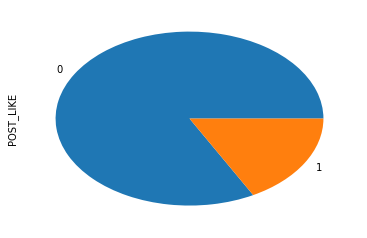

In [14]:
df_interaction['POST_LIKE'].value_counts(sort=True).plot.pie()
#REVIEW!!!!!!

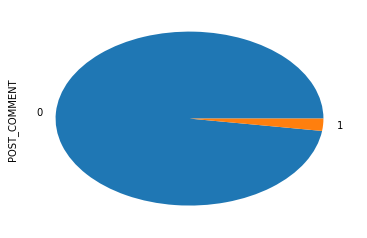

In [15]:
df_interaction['POST_COMMENT'].value_counts(sort=True).plot.pie()

In [16]:
interactions = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },        
        {
            "name": "POST_LIKE",
            "type": "int",
            "categorical": True
        },
        {
            "name": "POST_COMMENT",
            "type": "int",
            "categorical": True
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

with open('schema/interactions.json', 'w') as json_file:
    json.dump(interactions, json_file, indent = 4)


schema_arn = create_schema(name = 'InteractionSchema', schemaFile = 'schema/interactions.json')
print(schema_arn) 

dataset_arn = crate_dataset(name = 'InteractionDataset',
        schemaArn = schema_arn['InteractionSchema'],
        datasetGroupArn = 'arn:aws:personalize:us-east-1::dataset-group/MadlipzDatasetGroup',
        datasetType = 'Interactions')
print(dataset_arn)

An error occurred (ResourceAlreadyExistsException) when calling the CreateSchema operation: Another resource with Arn arn:aws:personalize:us-east-1::schema/InteractionSchema already exists.
{'InteractionSchema': 'arn:aws:personalize:us-east-1::schema/InteractionSchema', 'ItemSchema': 'arn:aws:personalize:us-east-1::schema/ItemSchema', 'UserSchema': 'arn:aws:personalize:us-east-1::schema/UserSchema'}
{'InteractionDataset': 'arn:aws:personalize:us-east-1::dataset/MadlipzDatasetGroup/INTERACTIONS', 'ItemsDataset': 'arn:aws:personalize:us-east-1::dataset/MadlipzDatasetGroup/ITEMS', 'UserDataset': 'arn:aws:personalize:us-east-1::dataset/MadlipzDatasetGroup/USERS'}


# Dataset group

In [17]:
# need to be done one time
def create_dataset_group(name = 'MadlipzDatasetGroup'):
    try:
        response = personalize.create_dataset_group(name = name)
        dsg_arn = response['datasetGroupArn']

        description = personalize.describe_dataset_group(datasetGroupArn = dsg_arn)['datasetGroup']

        print('Name: ' + description['name'])
        print('ARN: ' + description['datasetGroupArn'])
        print('Status: ' + description['status'])
    except:
        print(personalize.list_dataset_groups())
    
create_dataset_group(name = 'MadlipzDatasetGroup')

{'datasetGroups': [{'name': 'MadlipzDatasetGroup', 'datasetGroupArn': 'arn:aws:personalize:us-east-1::dataset-group/MadlipzDatasetGroup', 'status': 'ACTIVE', 'creationDateTime': datetime.datetime(2020, 7, 29, 20, 46, 47, 601000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 7, 29, 20, 46, 56, 108000, tzinfo=tzlocal())}], 'ResponseMetadata': {'RequestId': 'e18f61ee-1853-4246-ae41-1657c61fb160', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Thu, 08 Oct 2020 03:36:11 GMT', 'x-amzn-requestid': 'e18f61ee-1853-4246-ae41-1657c61fb160', 'content-length': '240', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [18]:
def create_dataset_import_job(jobName, datasetArn, dataLocation):
    try:
        response = personalize.create_dataset_import_job(
            jobName = jobName,
            datasetArn = datasetArn,
            dataSource = { 'dataLocation': dataLocation },
            roleArn = roleArn)

        dsij_arn = response['datasetImportJobArn']

        print ('Dataset Import Job arn: ' + dsij_arn)
    except Exception as e:
        print (e)
    

    description = personalize.list_dataset_import_jobs()['datasetImportJobs']
    print('Dataset Import Jobs: ' , description)

In [19]:
create_dataset_import_job(jobName='UsersImportJobName', 
                         datasetArn= dataset_arn['UserDataset'],
                         dataLocation='s3://madlipz-data-lake/personalize/USERS.csv')

Dataset Import Job arn: arn:aws:personalize:us-east-1::dataset-import-job/UsersImportJobName
Dataset Import Jobs:  [{'datasetImportJobArn': 'arn:aws:personalize:us-east-1::dataset-import-job/UsersImportJobName', 'jobName': 'UsersImportJobName', 'status': 'CREATE PENDING', 'creationDateTime': datetime.datetime(2020, 10, 8, 3, 36, 21, 207000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 3, 36, 21, 207000, tzinfo=tzlocal())}]


In [20]:
create_dataset_import_job(jobName='ItemsImportJobName', 
                         datasetArn= dataset_arn['ItemsDataset'],
                         dataLocation='s3://madlipz-data-lake/personalize/ITEMS.csv')

Dataset Import Job arn: arn:aws:personalize:us-east-1::dataset-import-job/ItemsImportJobName
Dataset Import Jobs:  [{'datasetImportJobArn': 'arn:aws:personalize:us-east-1::dataset-import-job/ItemsImportJobName', 'jobName': 'ItemsImportJobName', 'status': 'CREATE PENDING', 'creationDateTime': datetime.datetime(2020, 10, 8, 3, 36, 22, 778000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 3, 36, 22, 778000, tzinfo=tzlocal())}, {'datasetImportJobArn': 'arn:aws:personalize:us-east-1::dataset-import-job/UsersImportJobName', 'jobName': 'UsersImportJobName', 'status': 'CREATE PENDING', 'creationDateTime': datetime.datetime(2020, 10, 8, 3, 36, 21, 207000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 3, 36, 21, 207000, tzinfo=tzlocal())}]


In [21]:
create_dataset_import_job(jobName='InteractionImportJobName', 
                         datasetArn= dataset_arn['InteractionDataset'],
                         dataLocation='s3://madlipz-data-lake/personalize/INTERACTIONS.csv')

Dataset Import Job arn: arn:aws:personalize:us-east-1::dataset-import-job/InteractionImportJobName
Dataset Import Jobs:  [{'datasetImportJobArn': 'arn:aws:personalize:us-east-1::dataset-import-job/InteractionImportJobName', 'jobName': 'InteractionImportJobName', 'status': 'CREATE PENDING', 'creationDateTime': datetime.datetime(2020, 10, 8, 3, 36, 23, 969000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 3, 36, 23, 969000, tzinfo=tzlocal())}, {'datasetImportJobArn': 'arn:aws:personalize:us-east-1::dataset-import-job/ItemsImportJobName', 'jobName': 'ItemsImportJobName', 'status': 'CREATE PENDING', 'creationDateTime': datetime.datetime(2020, 10, 8, 3, 36, 22, 778000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 3, 36, 22, 778000, tzinfo=tzlocal())}, {'datasetImportJobArn': 'arn:aws:personalize:us-east-1::dataset-import-job/UsersImportJobName', 'jobName': 'UsersImportJobName', 'status': 'CREATE PENDING', 'creationDateTime': datetime.da

In [22]:
print(personalize.list_dataset_groups()['datasetGroups'][0]['datasetGroupArn'])

arn:aws:personalize:us-east-1::dataset-group/MadlipzDatasetGroup


In [23]:
!aws personalize list-recipes

{
    "recipes": [
        {
            "name": "aws-hrnn",
            "recipeArn": "arn:aws:personalize:::recipe/aws-hrnn",
            "status": "ACTIVE",
            "creationDateTime": 1560124800.0,
            "lastUpdatedDateTime": 1598374620.148
        },
        {
            "name": "aws-hrnn-coldstart",
            "recipeArn": "arn:aws:personalize:::recipe/aws-hrnn-coldstart",
            "status": "ACTIVE",
            "creationDateTime": 1560124800.0,
            "lastUpdatedDateTime": 1598374620.148
        },
        {
            "name": "aws-hrnn-metadata",
            "recipeArn": "arn:aws:personalize:::recipe/aws-hrnn-metadata",
            "status": "ACTIVE",
            "creationDateTime": 1560124800.0,
            "lastUpdatedDateTime": 1598374620.148
        },
        {
            "name": "aws-personalized-ranking",
            "recipeArn": "arn:aws:personalize:::recipe/aws-personalized-ranking",
            "status": "ACTIVE",
            "creationDateTime"

# Create Solution

In [33]:
name = "first-solution-aws-user-personalization"
print ('Creating solution', name)

response = personalize.create_solution(
    name = name,
    datasetGroupArn = personalize.list_dataset_groups()['datasetGroups'][0]['datasetGroupArn'],
    recipeArn = 'arn:aws:personalize:::recipe/aws-user-personalization'
#     performAutoML = True
)

# Get the solution ARN.
solution_arn = response['solutionArn']
print('Solution ARN: ' + solution_arn)

# Use the solution ARN to get the solution status.
solution_description = personalize.describe_solution(solutionArn = solution_arn)['solution']
print('Solution status: ' + solution_description['status'])

# Use the solution ARN to create a solution version.
print ('Creating solution version')
response = personalize.create_solution_version(solutionArn = solution_arn)
solution_version_arn = response['solutionVersionArn']
print('Solution version ARN: ' + solution_version_arn)

# Use the solution version ARN to get the solution version status.
solution_version_description = personalize.describe_solution_version(
    solutionVersionArn = solution_version_arn)['solutionVersion']
print('Solution version status: ' + solution_version_description['status'])

Creating solution first-solution-aws-user-personalization
Solution ARN: arn:aws:personalize:us-east-1::solution/first-solution-aws-user-personalization
Solution status: ACTIVE
Creating solution version
Solution version ARN: arn:aws:personalize:us-east-1::solution/first-solution-aws-user-personalization/beed8420
Solution version status: CREATE PENDING


In [34]:
# Use the solution version ARN to get the solution version status.
print(personalize.list_solution_versions()['solutionVersions'])
# solution_version_description = personalize.describe_solution_version(
#     solutionVersionArn = 'arn:aws:personalize:us-east-1::solution/FirstSolution')['solutionVersion']
# print('Solution version status: ' + solution_version_description['status'])

[{'solutionVersionArn': 'arn:aws:personalize:us-east-1::solution/FirstSolution-aws-user-personalization/4e75477e', 'status': 'CREATE IN_PROGRESS', 'creationDateTime': datetime.datetime(2020, 10, 8, 4, 7, 38, 488000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 4, 7, 39, 621000, tzinfo=tzlocal())}, {'solutionVersionArn': 'arn:aws:personalize:us-east-1::solution/first-solution-aws-hrnn-metadata/4480c8bc', 'status': 'CREATE IN_PROGRESS', 'creationDateTime': datetime.datetime(2020, 10, 8, 4, 10, 58, 662000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 4, 11, 5, 264000, tzinfo=tzlocal())}, {'solutionVersionArn': 'arn:aws:personalize:us-east-1::solution/first-solution-aws-hrnn/58ab9958', 'status': 'CREATE IN_PROGRESS', 'creationDateTime': datetime.datetime(2020, 10, 8, 4, 9, 38, 579000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2020, 10, 8, 4, 10, 7, 231000, tzinfo=tzlocal())}, {'solutionVersionArn': 'arn:aws:personali

In [35]:
# print(personalize.list_solution_versions()['solutionVersions'])
modelPerformance = []
for solutionVersion in personalize.list_solution_versions()['solutionVersions']:
    solutionName = solutionVersion['solutionVersionArn'].split('/')[-2]
    print(solutionName)
    response = personalize.get_solution_metrics(solutionVersionArn = solutionVersion['solutionVersionArn'])
#     print(response['metrics'])
    mp = response['metrics']
    mp['name'] = solutionName
    modelPerformance.append(mp)
    print('-' * 50)
    
df= pd.DataFrame(modelPerformance)
df

FirstSolution-aws-user-personalization
--------------------------------------------------
first-solution-aws-hrnn-metadata
--------------------------------------------------
first-solution-aws-hrnn
--------------------------------------------------
first-solution-aws-personalized-ranking
--------------------------------------------------
first-solution-aws-popularity-count
--------------------------------------------------
first-solution-aws-sims
--------------------------------------------------
first-solution-aws-user-personalization
--------------------------------------------------


,coverage,mean_reciprocal_rank_at_25,name,normalized_discounted_cumulative_gain_at_10,normalized_discounted_cumulative_gain_at_25,normalized_discounted_cumulative_gain_at_5,precision_at_10,precision_at_25,precision_at_5
0,0.0200,0.0468,FirstSolution-aws-user-personalization,0.0539,0.0742,0.0446,0.0096,0.0075,0.0129
1,0.0025,0.0009,first-solution-aws-hrnn-metadata,0.0018,0.0024,0.0010,0.0005,0.0003,0.0005
2,0.0480,0.0157,first-solution-aws-hrnn,0.0186,0.0234,0.0170,0.0027,0.0019,0.0046
3,0.0006,0.0006,first-solution-aws-personalized-ranking,0.0000,0.0027,0.0000,0.0000,0.0005,0.0000
4,0.0006,0.0025,first-solution-aws-popularity-count,0.0050,0.0055,0.0043,0.0006,0.0003,0.0009
5,0.0358,0.0455,first-solution-aws-sims,0.0586,0.0642,0.0491,0.0083,0.0043,0.0111
6,0.0227,0.0524,first-solution-aws-user-personalization,0.0591,0.0795,0.0497,0.0104,0.0081,0.0142


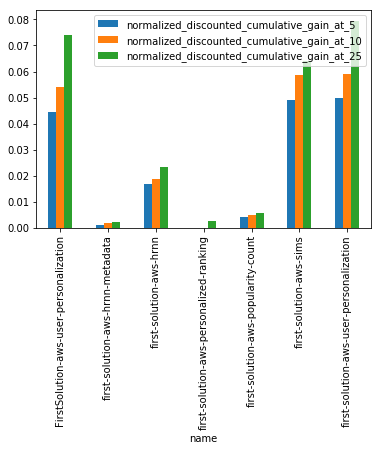

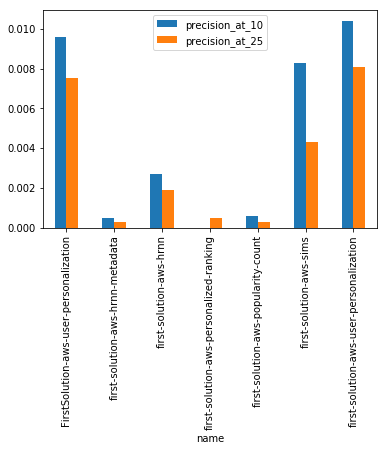

In [39]:
# gca stands for 'get current axis'
# ax = plt.gca()

df.plot(kind='bar', x='name', y=['normalized_discounted_cumulative_gain_at_5','normalized_discounted_cumulative_gain_at_10', 'normalized_discounted_cumulative_gain_at_25'])
plt.xticks(rotation=90)
df.plot(kind='bar', x='name', y=['precision_at_10', 'precision_at_25'])
plt.xticks(rotation=90)

# df.plot()

plt.show()

# Campaign

In [ ]:
response = personalize.create_campaign(
    name = 'First-sim-Campaign',
    solutionVersionArn = personalize.list_solution_versions()['solutionVersions'][0]['solutionVersionArn'],
    minProvisionedTPS = 10)

arn = response['campaignArn']

description = personalize.describe_campaign(campaignArn = arn)['campaign']
print('Name: ' + description['name'])
print('ARN: ' + description['campaignArn'])
print('Status: ' + description['status'])

In [ ]:
personalizeRt = boto3.client('personalize-runtime')

response = personalizeRt.get_recommendations(
    campaignArn = 'arn:aws:personalize:us-east-1::campaign/FirstCampaign',
    userId = '87557')

print("Recommended items")
for item in response['itemList']:
    print (item['itemId'])

In [ ]:
response = personalizeRt.get_recommendations(
    campaignArn = 'arn:aws:personalize:us-east-1::campaign/FirstCampaign',
    userId = '25746839',
    context = {
      'CLIP_CATEGORY': 'cartoons'
    }
)

# print("Recommended items", response['itemList'])
# for item in response['itemList']:
#     print (item['itemId'])
    
# print(list(map(lambda x : x['itemId'], response['itemList'])))
# response['itemList']
print(df_user.loc[ df_user['USER_ID'] == 25746839 ])
df_result = df_item[df_item['ITEM_ID'].isin(list(map(lambda x : x['itemId'], response['itemList'])))]

df_result.head(10)

In [ ]:
# 72953299
response = personalizeRt.get_recommendations(
    campaignArn = 'arn:aws:personalize:us-east-1::campaign/First-sim-Campaign',
    itemId = '72953299',
#     context = {
#       'CLIP_CATEGORY': 'cartoons'
#     }
)

# print("Recommended items", response['itemList'])
# for item in response['itemList']:
#     print (item['itemId'])
    
# print(list(map(lambda x : x['itemId'], response['itemList'])))
# response['itemList']
print(df_item.loc[ df_item['ITEM_ID'] == 72953299 ])
df_result = df_item[df_item['ITEM_ID'].isin(list(map(lambda x : x['itemId'], response['itemList'])))]

df_result.head(10)